# Step 1 Data Preprarion and cleaning 

In [25]:
import numpy as np
import cv2 
import os

additional_path = "archive/train/" 
list_of_files = ["angry/","disgust/", "fear/", "happy/", "neutral/", "sad/", "surprise/"]


def load_data(additional_path):
    data = []
    labels = []
    for i in range(len(list_of_files)):
        path = additional_path + list_of_files[i]
        for img in os.listdir(path):
            img_load = cv2.imread( os.path.join(path, img) , cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_load, (48,48))
            if not(len(img_resize.shape) == 2):
                img_resize = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
            #flatten the image 
            img_resize = img_resize.flatten()
            data.append(img_resize)
            labels.append(i)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels





In [4]:
if __name__ == "__main__":
    data, labels = load_data()
    print(data.shape)
    print(labels.shape)

(28709, 2304)
(28709,)


# Feature extraction 

In [ ]:
# dimensionality reduction using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = data/255.0
pca = PCA(n_components=0.95) # keep 95% of variance
#standardScaler
data = StandardScaler().fit_transform(data)
data_pca = pca.fit_transform(data)
print("Original shape:", data.shape)
print("PCA shape:", data_pca.shape)


Original shape: (28709, 2304)
PCA shape: (28709, 273)


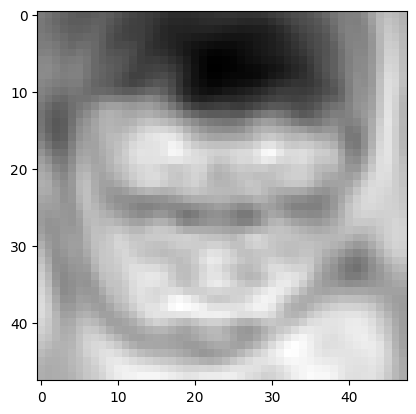

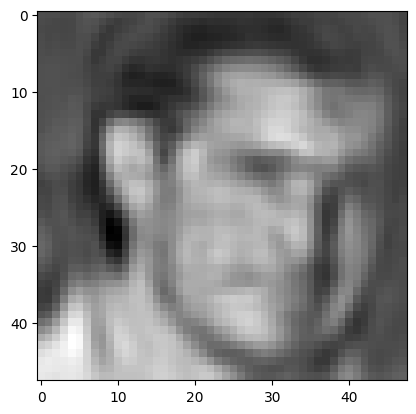

In [13]:
#display pca images
import matplotlib.pyplot as plt

for i in range(2):
    original_data = pca.inverse_transform(data_pca[i].reshape(1, -1))
    plt.imshow(original_data.reshape(48, 48), cmap="gray")
    plt.show()


HOG features shape: (28709, 900)
Feature vector shape for image 0: (900,)


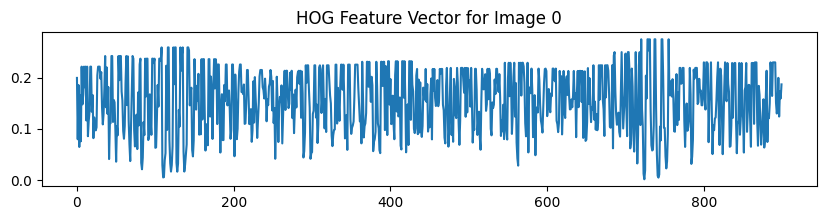

Feature vector shape for image 1: (900,)


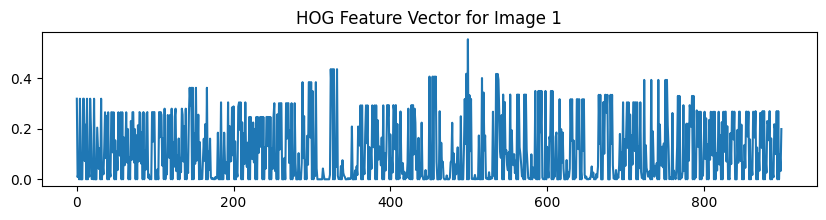

In [21]:
#impllement hod feature extraction
hog = cv2.HOGDescriptor(
    _winSize=(48, 48),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9
)
def extract_hog_features(data):
    hog_features = []
    for img in data:
        img = img.reshape(48, 48)
        
        # 1. Ensure the data is in the 0-255 range
        if img.max() <= 1.0:
            img = (img * 255).astype('uint8')
        else:
            img = img.astype('uint8')
            
        # 2. Compute HOG
        hog_feature = hog.compute(img)
        hog_features.append(hog_feature.flatten())
    return np.array(hog_features)

hog_features = extract_hog_features(data)
print("HOG features shape:", hog_features.shape)

import matplotlib.pyplot as plt

for i in range(2):
    # 1. Reshape and ensure uint8 type
    img = data[i].reshape(48, 48)
    if img.dtype != 'uint8':
        img = (img * 255).astype('uint8') if img.max() <= 1.0 else img.astype('uint8')
    
    # 2. Compute HOG
    hog_feature = hog.compute(img)
    
    # NOTE: hog_feature.reshape((6, 6)) will likely fail because 
    # the feature vector length is much larger than the pixel grid.
    print(f"Feature vector shape for image {i}: {hog_feature.shape}")
    
    # Simple visualization of the feature vector values
    plt.figure(figsize=(10, 2))
    plt.plot(hog_feature)
    plt.title(f"HOG Feature Vector for Image {i}")
    plt.show()

# Model selection and training 

In [22]:
# 3 models : logistic regression, svm, random forest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

LR_model = LogisticRegression(max_iter=500)
SVM_model = SVC()
RF_model = RandomForestClassifier(n_estimators=100)
LR_model.fit(hog_features, labels)
SVM_model.fit(hog_features, labels)
RF_model.fit(hog_features, labels)
print("Models trained successfully.")

#compare performance
from sklearn.model_selection import cross_val_score
LR_scores = cross_val_score(LR_model, hog_features, labels, cv=5)
SVM_scores = cross_val_score(SVM_model, hog_features, labels, cv=5)
RF_scores = cross_val_score(RF_model, hog_features, labels, cv=5)
print("Logistic Regression CV Scores:", LR_scores)
print("SVM CV Scores:", SVM_scores)
print("Random Forest CV Scores:", RF_scores)


Models trained successfully.
Logistic Regression CV Scores: [0.38592825 0.39707419 0.39132706 0.39359108 0.37641526]
SVM CV Scores: [0.43051202 0.43120864 0.43712992 0.44078718 0.42605818]
Random Forest CV Scores: [0.4219784  0.41814699 0.41971439 0.42877046 0.41943912]


In [23]:
import joblib

# Exporting your models
joblib.dump(LR_model, 'logistic_regression_model.joblib')
joblib.dump(SVM_model, 'svm_model.joblib')
joblib.dump(RF_model, 'random_forest_model.joblib')
joblib.dump(hog_features, 'hog_scaler.joblib')

import json

hog_params = {
    "winSize": [48, 48],
    "blockSize": [16, 16],
    "blockStride": [8, 8],
    "cellSize": [8, 8],
    "nbins": 9
}

with open('hog_config.json', 'w') as f:
    json.dump(hog_params, f)

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
with open('emotion_labels.json', 'w') as f:
    json.dump(emotions, f)

print("Models exported successfully!")

Models exported successfully!


In [26]:
test_data_location = "archive/test/"

test_data, test_labels = load_data(test_data_location)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
hog_test_features = extract_hog_features(test_data)
print("HOG test features shape:", hog_test_features.shape)


Test data shape: (7178, 2304)
Test labels shape: (7178,)
HOG test features shape: (7178, 900)


Actual Emotion: Neutral
--- Predictions ---
Logistic Regression: Happy
SVM:                 Happy
Random Forest:       Surprise


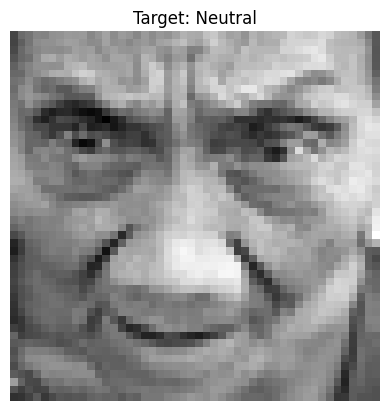

In [30]:
# Define your emotion labels (standard for FER2013)
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Select a single sample
index = 6787 
sample_feature = hog_test_features[index:index+1]
actual_label = test_labels[index]

# Get predictions
lr_pred = LR_model.predict(sample_feature)[0]
svm_pred = SVM_model.predict(sample_feature)[0]
rf_pred = RF_model.predict(sample_feature)[0]

# Display results
print(f"Actual Emotion: {emotion_labels[actual_label]}")
print(f"--- Predictions ---")
print(f"Logistic Regression: {emotion_labels[lr_pred]}")
print(f"SVM:                 {emotion_labels[svm_pred]}")
print(f"Random Forest:       {emotion_labels[rf_pred]}")

# Show the image being predicted
plt.imshow(test_data[index].reshape(48, 48), cmap='gray')
plt.title(f"Target: {emotion_labels[actual_label]}")
plt.axis('off')
plt.show()